Mounted at /content/drive
drive mounted
unziped the files
sample data removed
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
GPU: NVIDIA A100-SXM4-80GB
Total VRAM (GB): 85.09
🚀 Starting Final Training...
Ultralytics 8.4.15 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (NVIDIA A100-SXM4-80GB, 81153MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=128, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/dataset/data.yaml, degrees

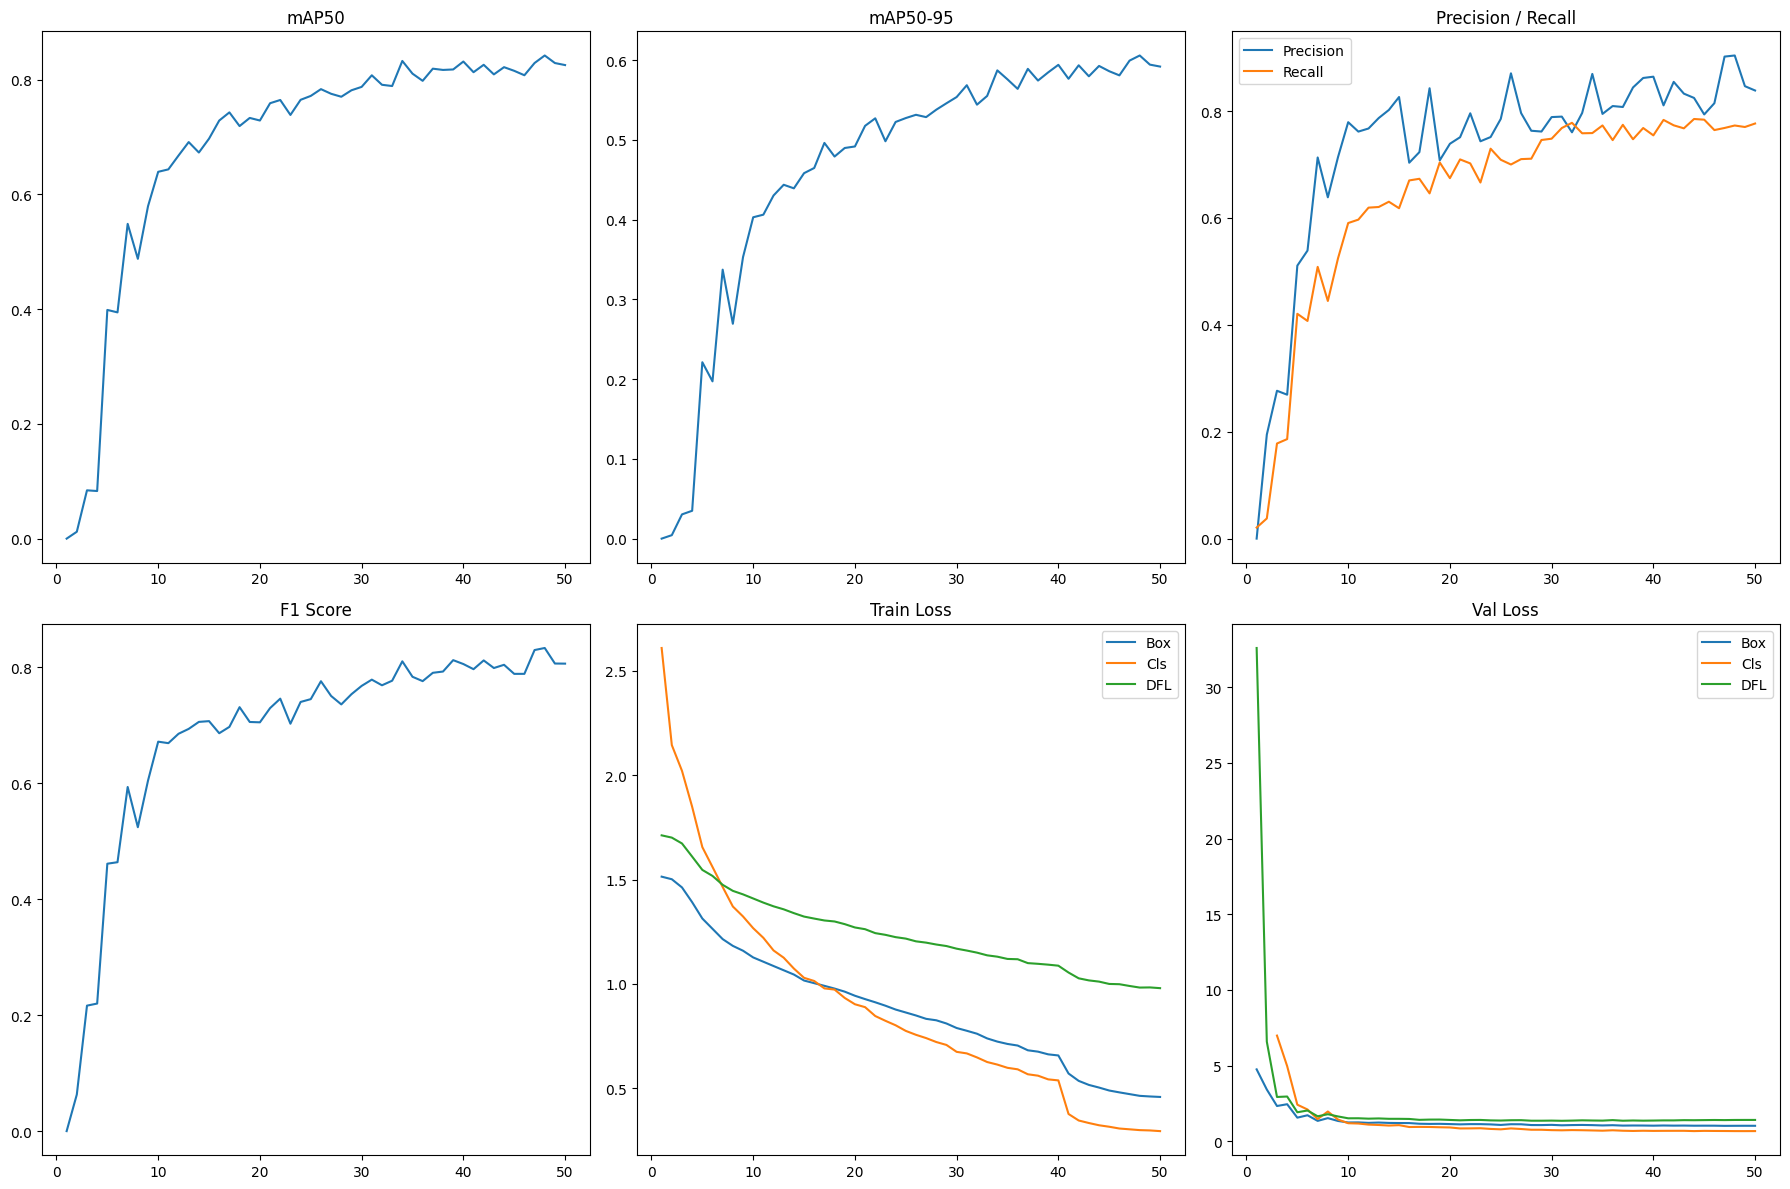

📄 PDF Report Generated
⬇️ Downloading best.pt ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ FINAL TRAINING COMPLETE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("drive mounted")
!unzip -q /content/dataset.zip -d /content/
print("unziped the files")
!rm -rf /content/sample_data/
print("sample data removed")
# ==========================================================
# 1️⃣ Install Dependencies
# ==========================================================
!pip install -q ultralytics pandas openpyxl matplotlib fpdf

from ultralytics import YOLO
import torch, os, json
import pandas as pd
import matplotlib.pyplot as plt
from fpdf import FPDF
from google.colab import files

# ==========================================================
# 2️⃣ A100 GPU Optimization
# ==========================================================
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

print("GPU:", torch.cuda.get_device_name(0))
print("Total VRAM (GB):", round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2))

# ==========================================================
# 3️⃣ USER SETTINGS (Balanced + Deployment Friendly)
# ==========================================================
OUTPUT_ROOT = "/content/drive/MyDrive/my_training_outputs"
PROJECT_NAME = "weapon_training"
EXP_NAME = "final_yolov8m"

DATA_PATH = "/content/dataset/data.yaml"

IMG_SIZE = 640        # Real-time friendly
BATCH_SIZE = 128       # Safe for A100
EPOCHS = 50
WORKERS = 12
CACHE = True

os.makedirs(OUTPUT_ROOT, exist_ok=True)

SAVE_DIR = os.path.join(OUTPUT_ROOT, PROJECT_NAME, EXP_NAME)
BEST_MODEL = os.path.join(SAVE_DIR, "weights", "best.pt")
RESULTS_CSV = os.path.join(SAVE_DIR, "results.csv")

# ==========================================================
# 4️⃣ Train Model
# ==========================================================
print("🚀 Starting Final Training...")

model = YOLO("yolov8m.pt")

model.train(
    data=DATA_PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=0,
    workers=WORKERS,
    cache=CACHE,
    optimizer="AdamW",
    lr0=0.006,
    weight_decay=0.0005,
    cos_lr=True,
    close_mosaic=10,
    patience=20,
    amp=True,
    pretrained=True,
    project=os.path.join(OUTPUT_ROOT, PROJECT_NAME),
    name=EXP_NAME,
    exist_ok=True,
    save=True
)

# ==========================================================
# 5️⃣ Save Training History
# ==========================================================
if os.path.exists(RESULTS_CSV):
    df = pd.read_csv(RESULTS_CSV)
    df.to_excel(os.path.join(SAVE_DIR, "training_history.xlsx"), index=False)
    print("💾 Training history saved")

# ==========================================================
# 6️⃣ Plot Training Curves
# ==========================================================
if os.path.exists(RESULTS_CSV):
    df = pd.read_csv(RESULTS_CSV)

    df["F1"] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / \
               (df['metrics/precision(B)'] + df['metrics/recall(B)'] + 1e-6)

    plt.figure(figsize=(18, 12))

    plt.subplot(2,3,1)
    plt.plot(df['epoch'], df['metrics/mAP50(B)'])
    plt.title("mAP50")

    plt.subplot(2,3,2)
    plt.plot(df['epoch'], df['metrics/mAP50-95(B)'])
    plt.title("mAP50-95")

    plt.subplot(2,3,3)
    plt.plot(df['epoch'], df['metrics/precision(B)'], label="Precision")
    plt.plot(df['epoch'], df['metrics/recall(B)'], label="Recall")
    plt.legend()
    plt.title("Precision / Recall")

    plt.subplot(2,3,4)
    plt.plot(df['epoch'], df['F1'])
    plt.title("F1 Score")

    plt.subplot(2,3,5)
    plt.plot(df['epoch'], df['train/box_loss'], label="Box")
    plt.plot(df['epoch'], df['train/cls_loss'], label="Cls")
    plt.plot(df['epoch'], df['train/dfl_loss'], label="DFL")
    plt.legend()
    plt.title("Train Loss")

    plt.subplot(2,3,6)
    plt.plot(df['epoch'], df['val/box_loss'], label="Box")
    plt.plot(df['epoch'], df['val/cls_loss'], label="Cls")
    plt.plot(df['epoch'], df['val/dfl_loss'], label="DFL")
    plt.legend()
    plt.title("Val Loss")

    plt.tight_layout()
    curve_path = os.path.join(SAVE_DIR, "training_curves.png")
    plt.savefig(curve_path)
    plt.show()

# ==========================================================
# 7️⃣ Generate PDF Report
# ==========================================================
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=10)
pdf.add_page()
pdf.set_font("Arial", size=12)

pdf.cell(200, 10, "YOLOv8 Weapon Detection Training Report", ln=True)

if os.path.exists(BEST_MODEL):
    pdf.cell(200, 10, f"Best Model Path:", ln=True)
    pdf.multi_cell(0, 8, BEST_MODEL)

if os.path.exists(curve_path):
    pdf.image(curve_path, w=180)

PDF_PATH = os.path.join(SAVE_DIR, "training_report.pdf")
pdf.output(PDF_PATH)

print("📄 PDF Report Generated")

# ==========================================================
# 8️⃣ Download Best Model
# ==========================================================
if os.path.exists(BEST_MODEL):
    print("⬇️ Downloading best.pt ...")
    files.download(BEST_MODEL)

print("✅ FINAL TRAINING COMPLETE")